In [1]:
import os
import librosa
import numpy as np
import hdbscan
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# === 1. Preprocessing: load, normalize, trim/pad audio ===
def preprocess_kick(path, target_sr=44100, window=1.0):
    y, orig_sr = librosa.load(path, sr=None, mono=False)
    if y.ndim > 1:
        y = np.mean(y, axis=0)
    if orig_sr != target_sr:
        y = librosa.resample(y=y, orig_sr=orig_sr, target_sr=target_sr)
    y, _ = librosa.effects.trim(y, top_db=40)
    y = librosa.effects.preemphasis(y)
    # Normalize with RMS
    rms = np.sqrt(np.mean(y ** 2))
    if rms > 1e-8:
        y = y / rms
    window_len = int(target_sr * window)
    if len(y) < window_len:
        y = np.pad(y, (0, window_len - len(y)))
    else:
        y = y[:window_len]
    return y



# === 2. Embedding extraction: log-mel spectrogram, flattened ===
def extract_embedding(y, sr=44100, n_mels=128, hop_length=512):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.flatten()

def advanced_kick_features(y, sr=44100):
    # Split into attack and tail (customize timing)
    attack_len = int(0.05 * sr)  # 50ms
    tail_start = int(0.15 * sr)
    tail = y[tail_start:]
    attack = y[:attack_len]

    # Energy features
    attack_energy = np.mean(np.abs(attack))
    tail_energy = np.mean(np.abs(tail))
    energy_ratio = attack_energy / (tail_energy + 1e-6)

    # ZCR features
    zcr_attack = librosa.feature.zero_crossing_rate(attack).mean()
    zcr_tail = librosa.feature.zero_crossing_rate(tail).mean()

    # Spectral centroid/roll-off
    centroid_attack = librosa.feature.spectral_centroid(y=attack, sr=sr).mean()
    centroid_tail = librosa.feature.spectral_centroid(y=tail, sr=sr).mean()
    rolloff_attack = librosa.feature.spectral_rolloff(y=attack, sr=sr).mean()
    rolloff_tail = librosa.feature.spectral_rolloff(y=tail, sr=sr).mean()

    # Transient sharpness: onset strength
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    transient_sharpness = onset_env.max() / (onset_env.mean() + 1e-6)

    # Combine
    return np.array([
        energy_ratio, zcr_attack, zcr_tail, centroid_attack, centroid_tail,
        rolloff_attack, rolloff_tail, transient_sharpness
    ])


# === 3. Feature dataset creation ===
kick_folder = Path('../data/RHSP')
kick_paths = [str(p) for p in kick_folder.rglob("*.wav")]
print(f"Found {len(kick_paths)} .wav files")
if len(kick_paths) > 0:
    print(f"First file: {kick_paths[0]}")
else:
    print(f"Warning: No .wav files found in {kick_folder.absolute()}")
    raise FileNotFoundError(f"No .wav files found in {kick_folder.absolute()}")

embeddings = []
for p in kick_paths:
    y = preprocess_kick(p)
    emb = advanced_kick_features(y)
    embeddings.append(emb)
embeddings = np.array(embeddings)

# === 4. Standardize features (global z-score) ===
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)

# === 5. PCA dimensionality reduction ===
# pca = PCA(n_components=30)
# X_pca = pca.fit_transform(X)


c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 217 .wav files
First file: ..\data\RHSP\BK-72 - A bit shitty G (Reverse Bass).wav


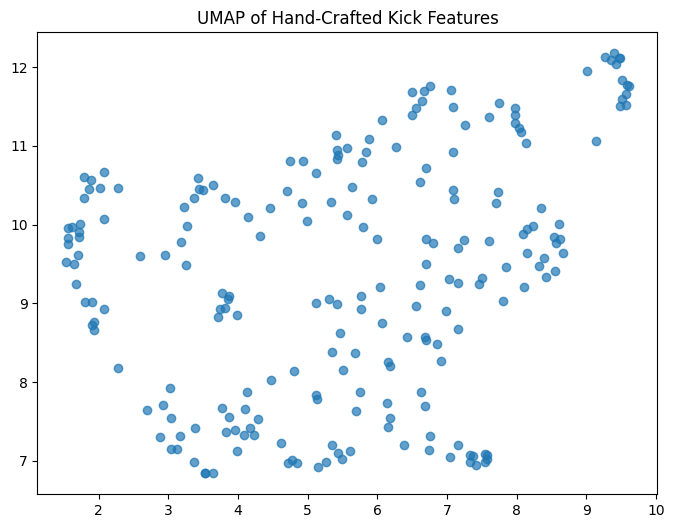

c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


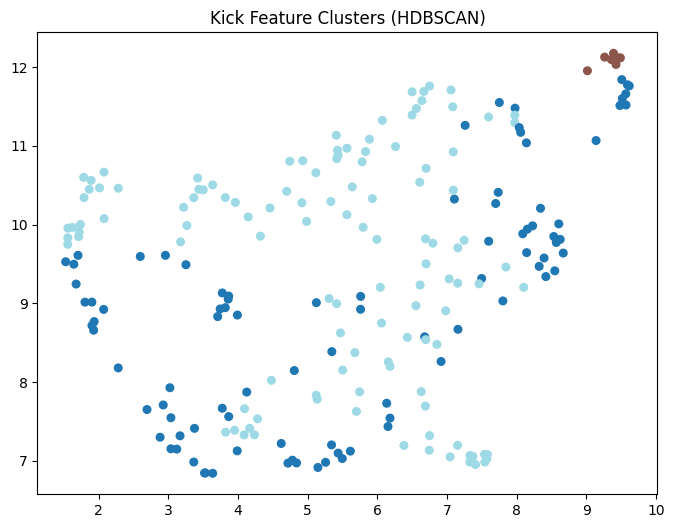

In [75]:
# UMAP visualization
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7)
plt.title("UMAP of Hand-Crafted Kick Features")
plt.show()

# Cluster with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
labels = clusterer.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab20', s=30)
plt.title("Kick Feature Clusters (HDBSCAN)")
plt.show()

c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


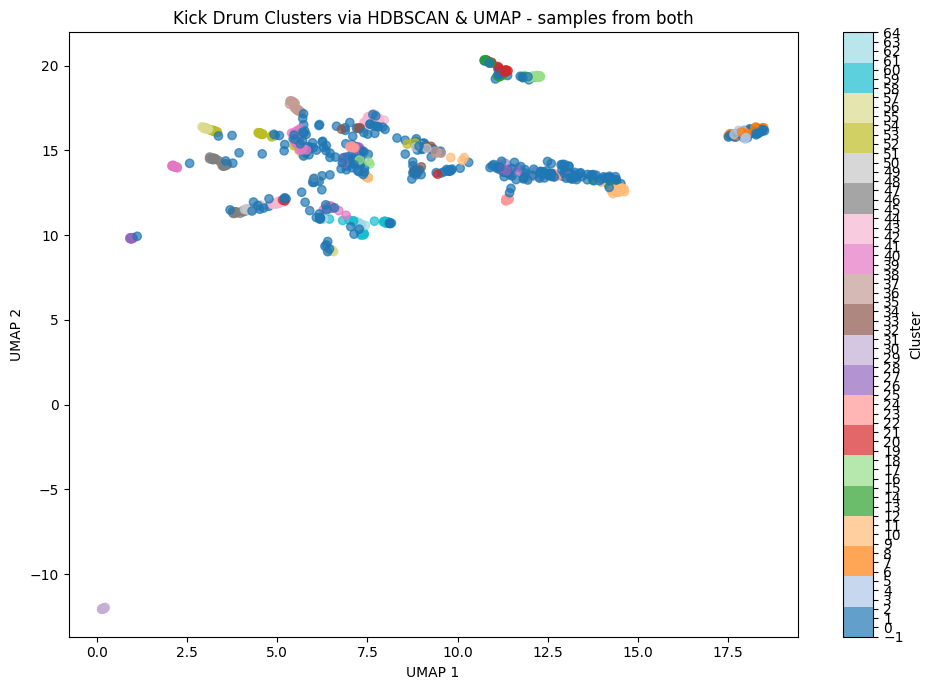

In [76]:
# 5. Clustering – HDBSCAN

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,   # tune up/down for genre focus!
    min_samples=2,        # can be equal to min_cluster_size
    metric='euclidean'
)
labels = clusterer.fit_predict(X_pca)

# 6. UMAP for 2D Visualization

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='tab20', alpha=0.7)
plt.title('Kick Drum Clusters via HDBSCAN & UMAP - samples from both')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')
plt.colorbar(scatter, ticks=range(-1,max(labels)+1), label='Cluster')
plt.tight_layout()
plt.show()

In [77]:
# 7. Export/listen: e.g., first 5 kicks per cluster

for cl in set(labels):
    if cl == -1: continue  # skip noise
    indices = np.where(labels == cl)[0][:5]
    print(f"Cluster {cl}:")
    for idx in indices:
        print(kick_paths[idx])
        # Optionally: play or export these for listening tests

# 8. Cluster metrics: silhouette score, etc
from sklearn.metrics import silhouette_score
valid_mask = labels != -1
if np.unique(labels[valid_mask]).size > 1:
    sil = silhouette_score(X_pca[valid_mask], labels[valid_mask])
    print(f"Silhouette score (excl. noise): {sil:.3f}")

Cluster 0:


IndexError: list index out of range